# **GoogleNet图像分类网络实现**

## **模型简介**

GoogLeNet是2014年Christian Szegedy提出的一种全新的深度学习结构，在这之前的AlexNet、VGG等结构都是通过增大网络的深度（层数）来获得更好的训练效果，但层数的增加会带来很多负作用，比如过拟合、梯度消失、梯度爆炸等。Inception的提出则从另一种角度来提升训练结果：能更高效的利用计算资源，在相同的计算量下能提取到更多的特征，从而提升训练结果。

与VGG不同，GoogLeNet并非提出具有更好的预训练模式和权重初始化的解决方法，而是尝试直接解决计算和梯度递减问题。

<div align=center><img src="./images/Inception.png"></div>
<div align='center '>
    <font face="楷体">图1-具有拆分-转换-合并策略的Inception v1模块</font>
</div >

首先，它使用称为Inception的模块探索了非对称网络设计的思想（请参见上图）。理想情况下，他们希望采用稀疏卷积或密集层来提高特征效率，但是现代硬件设计并非针对这种情况而定制。因此，他们认为，网络拓扑级别的稀疏性还可以在利用现有硬件功能的同时，帮助融合功能。

其次，它通过借鉴论文“网络中的网络（NiN）”来解决高计算成本的问题。引入1×1卷积滤波器以在进行繁重的计算操作（如5×5卷积内核）之前减小特征的尺寸。以后将该结构称为“Bottleneck”，并在许多后续网络中广泛使用。类似于NiN，它还使用平均池化层代替最终的完全连接层，以进一步降低成本。

再次，为帮助梯度流向更深的层次，GoogLeNet还对某些中间层输出或辅助输出使用了监督。由于其复杂性，该设计后来在图像分类网络中并不十分流行，但在计算机视觉的其他领域（如Hourglass网络）的姿态估计中越来越流行。

GoogLeNet在2014年的ISLVRC比赛的图像分类任务中获得冠军。之后Google又在v1的基础上相继推出了v2、v3、v4版本的GoogLeNet。
<div align=center><img src="./images/performance.png"></div>
<div align='center '>
    <font face="楷体">图2-GoogLeNet在2014 ISLVRC 图像分类任务中的表现</font>
</div >



## **数据处理**

### 数据准备

CIFAR-10数据集共有60000张32*32的彩色图像，分为10个类别，每类有6000张图，数据集一共有50000张训练图片和10000张评估图片。首先，如下示例使用`mindvision.dataset.Download`接口下载并解压，目前仅支持解析二进制版本的CIFAR-10文件（CIFAR-10 binary version）

In [1]:
# 安装mindvision，并卸载高版本opencv解决版本冲突
!pip install mindvision
!pip install "opencv-python-headless<4.3"

Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple


In [1]:
import os
from mindvision.dataset import DownLoad

dataset_url = "http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz"
save_dir = "./data"

dl = DownLoad()
if not(os.path.exists(save_dir+"/cifar-10-batches-bin")):
    dl.download_and_extract_archive(dataset_url, save_dir)

下载后的数据集结构目录如下：
```
        ./data
        └── cifar-10-batches-bin
            ├── data_batch_1.bin
            ├── data_batch_2.bin
            ├── data_batch_3.bin
            ├── data_batch_4.bin
            ├── data_batch_5.bin
            ├── test_batch.bin
            ├── readme.html
            └── batches.meta.text
```

In [2]:
# 建立索引-标签映射
index2label={}
with open(save_dir+'/cifar-10-batches-bin/batches.meta.txt','r') as fp:
    lines = fp.readlines()
    for index,line in enumerate(lines):
        line = line.strip('\n')
        if line:
            index2label[index]=line
index2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### 数据加载及增强

然后，使用`mindspore.dataset.Cifar10Dataset`接口来加载数据集，并进行相关图像增强操作。

In [3]:
import mindspore.dataset as ds
    
train_dataset = ds.Cifar10Dataset(save_dir+"/cifar-10-batches-bin",usage="train",shuffle=True) # 训练集
test_dataset = ds.Cifar10Dataset(save_dir+"/cifar-10-batches-bin",usage="test",shuffle=True)   # 测试集

In [4]:
import mindspore as ms
from mindspore.dataset import vision, transforms

def datapipe(dataset, batch_size,usage):
    image_transforms=[]
    if usage=="train":
        image_transforms = [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)), # 随机裁剪
            vision.RandomHorizontalFlip(), # 随机水平翻转
            vision.Resize((224, 224)),
            vision.Rescale(1.0 / 255.0,0),
            vision.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
            vision.HWC2CHW()
        ]
    elif usage=="test":
        image_transforms = [
            vision.Resize((224, 224)),
            vision.Rescale(1.0 / 255.0,0),
            vision.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
            vision.HWC2CHW()
        ]
    label_transform = transforms.TypeCast(ms.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat(2) #增强操作重复两次
    return dataset

In [5]:
BATCH_SIZE = 128

train_dataset = datapipe(train_dataset,BATCH_SIZE,"train")
test_dataset = datapipe(test_dataset,BATCH_SIZE,"test")

### 数据可视化

对CIFAR-10训练数据集进行可视化。

Image shape: (8, 3, 224, 224), Label: [1 5 4 7 2 9 0 5]


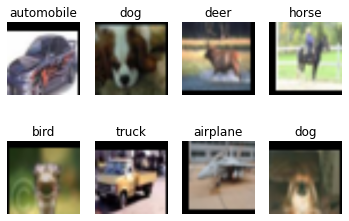

In [7]:
import numpy as np
import matplotlib.pyplot as plt

image, label = next(train_dataset.create_tuple_iterator())
images = image.asnumpy()
labels = label.asnumpy()

images = images[0:8]
labels = labels[0:8]
print(f"Image shape: {images.shape}, Label: {labels}")

plt.figure()
for i in range(1, 9):
    plt.subplot(2, 4, i)
    image_trans = np.transpose(images[i - 1], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{index2label[labels[i - 1]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

## **模型构建**

当处理完数据后，就可以来进行网络的搭建了。所有模型权重均以标准差为0.02的截尾正态分布随机初始化。

### Inception块

Inception块构成GoogLeNet中的基础卷积块，由4条并行的支路组成。前3条支路使用大小分别是1×1、3×3和5×5的卷积层来提取不同空间尺度下的信息，其中中间2个支路会对输入先做1×1卷积来减少输入通道数，以降低模型复杂度。第4条支路则使用3×3最大池化层，后接1×1卷积层来改变通道数。4条支路都使用了合适的填充来使输入与输出的高和宽一致。最后将每条线路的输出在通道维上连结,并向后进行传输。

<div align=center><img src="./images/inception1.png"></div>

<div align='center '>
     <font face="楷体">图3-Inception v1模块示意图</font>
    </div >
    

In [6]:
import mindspore as ms
import mindspore.nn as nn
from mindspore.ops import operations as P
from mindspore.common.initializer import TruncatedNormal

def weight_variable():
    """Weight variable."""
    return TruncatedNormal(0.02)


class Conv2dBlock(nn.Cell):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, pad_mode="same"):
        super(Conv2dBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                              padding=padding, pad_mode=pad_mode, weight_init=weight_variable())
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Inception(nn.Cell):
    """
    Inception Block
    """

    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.b1 = Conv2dBlock(in_channels, n1x1, kernel_size=1)
        self.b2 = nn.SequentialCell([Conv2dBlock(in_channels, n3x3red, kernel_size=1),
                                     Conv2dBlock(n3x3red, n3x3, kernel_size=3, padding=0)])
        self.b3 = nn.SequentialCell([Conv2dBlock(in_channels, n5x5red, kernel_size=1),
                                     Conv2dBlock(n5x5red, n5x5, kernel_size=3, padding=0)])
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, pad_mode="same")
        self.b4 = Conv2dBlock(in_channels, pool_planes, kernel_size=1)
        self.concat = P.Concat(axis=1)

    def construct(self, x):
        branch1 = self.b1(x)
        branch2 = self.b2(x)
        branch3 = self.b3(x)
        cell = self.maxpool(x)
        branch4 = self.b4(cell)
        return self.concat((branch1, branch2, branch3, branch4))
    

### 模型结构

GoogLeNet主要由Inception模块组成，整个网络框架分为5个模块。5个模块之间使用步幅为2的3x3最大池化层来减小输出高宽。
第1个模块使用了1个卷积，第2个模块使用了2个卷积，第3个模块串联2个inception，第4个模块串联5个inception，第5个模块串联2个inception，最后全局平均池化+全连接层输出。
<div align=center><img src="./images/structure.png"></div>

<div align='center '>
     <font face="楷体">图4-GoogleNet模型示意图</font>
    </div >
    
<div align=center><img src="./images/parameter.png"></div>

<div align='center '>
     <font face="楷体">图5-GoogLeNet各层参数设置</font>
    </div >
  

In [7]:
class GoogleNet(nn.Cell):
    """
    Googlenet architecture
    """

    def __init__(self, num_classes, include_top=True):
        super(GoogleNet, self).__init__()
        self.conv1 = Conv2dBlock(3, 64, kernel_size=7, stride=2, padding=0) # 7*7 卷积层
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same") # 3*3 最大池化层

        self.conv2 = Conv2dBlock(64, 64, kernel_size=1) # 1*1 卷积层
        self.conv3 = Conv2dBlock(64, 192, kernel_size=3, padding=0) # 3*3 卷积层
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same") # 3*3 最大池化层

        self.block3a = Inception(192, 64, 96, 128, 16, 32, 32) 
        self.block3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same") # 3*3 最大池化层

        self.block4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.block4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.block4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.block4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.block4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same") # 3*3 最大池化层

        self.block5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.block5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.dropout = nn.Dropout(keep_prob=0.4)
        self.include_top = include_top
        if self.include_top:
            self.mean = P.ReduceMean(keep_dims=True)
            self.flatten = nn.Flatten()
            self.classifier = nn.Dense(1024, num_classes, weight_init=weight_variable(),
                                       bias_init=weight_variable())


    def construct(self, x):
        """construct"""
        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.block3a(x)
        x = self.block3b(x)
        x = self.maxpool3(x)

        x = self.block4a(x)
        x = self.block4b(x)
        x = self.block4c(x)
        x = self.block4d(x)
        x = self.block4e(x)
        x = self.maxpool4(x)

        x = self.block5a(x)
        x = self.block5b(x)
        if not self.include_top:
            return x

        x = self.mean(x, (2, 3))
        x = self.flatten(x)
        x = self.classifier(x)

        return x

## **模型训练**

我们使用CIFAR-10数据集进行模型的训练和评估。

然后我们实例化GoogLeNet网络，传入图像分类个数为10类，并且进行参数和超参数的调整。其中，学习率初始化为0.1，采用指数级衰退，衰减率设置为0.6，总计进行90个epoch的衰减，确保模型能够较好地收敛；优化器采用Momentum，伴随权重衰退；损失函数使用常见的Softmax交叉熵损失。

In [10]:
from mindvision.engine.callback import LossMonitor
import mindspore.nn as nn

# 初始化网络结构
net = GoogleNet(num_classes=10)
epochs = 125
steps = train_dataset.get_dataset_size()
# 设置学习率
lr = nn.exponential_decay_lr(0.1,
                        0.6,
                        total_step=epochs * steps,
                        step_per_epoch=epochs,
                        decay_epoch=90)
# Momentem优化器
opt = nn.Momentum(filter(lambda x: x.requires_grad, net.get_parameters()),
                       learning_rate=lr,
                       momentum=0.9,
                       weight_decay=0.0005)
# 损失函数
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

我们定义训练信息回调类来将训练过程中的一些关键信息显示出来。在每个epoch训练完成会调用on_train_epoch_end函数。

In [11]:
class EvalCallBack(ms.Callback):  # 训练信息回调函数，设定固定epoch后对测试集进行评估
 
    def __init__(self, model, eval_dataset, eval_epoch, result_evaluation):
        self.model = model
        self.eval_dataset = eval_dataset
        self.eval_epoch = eval_epoch
        self.result_evaluation = result_evaluation

    def on_train_epoch_end(self, run_context):
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        if cur_epoch % self.eval_epoch == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.result_evaluation["epoch"].append(cur_epoch)
            self.result_evaluation["acc"].append(acc["accuracy"])
            print("Test acc:{}".format(acc["accuracy"]))

进行模型训练，设置checkpoint保存路径和模型训练过程中需要显示出来的关键信息，共训练125个epoch。

In [12]:
import mindspore as ms

# 选择执行模式为图模式；指定训练使用的平台为"Ascend"
ms.set_context(mode=ms.GRAPH_MODE, device_target="Ascend")

# 初始化模型，设置回调函数
result_eval = {"epoch": [], "acc": []}
model = ms.Model(net,loss,opt,metrics={"accuracy"})
eval_cb = EvalCallBack(model, test_dataset, 10, result_eval)

# 设置ckpt文件保存的参数,checkpoint文件保存在'./Googlenet'文件夹内
ckpt_config = ms.CheckpointConfig(save_checkpoint_steps=3000, keep_checkpoint_max=100)
ckpt_callback = ms.ModelCheckpoint(prefix='googlenet', directory='./GoogleNet', config=ckpt_config)

# 训练
model.train(125,train_dataset,callbacks=[ckpt_callback, LossMonitor(lr),eval_cb])

Epoch:[  0/125], step:[  782/  782], loss:[1.079/1.079], time:111465.945 ms, lr:0.09665
Epoch time: 119698.269 ms, per step time: 153.067 ms, avg loss: 1.079
Epoch:[  1/125], step:[  782/  782], loss:[0.901/0.901], time:58383.947 ms, lr:0.09342
Epoch time: 58393.974 ms, per step time: 74.673 ms, avg loss: 0.901
Epoch:[  2/125], step:[  782/  782], loss:[0.566/0.566], time:58388.840 ms, lr:0.09029
Epoch time: 58413.383 ms, per step time: 74.697 ms, avg loss: 0.566
Epoch:[  3/125], step:[  782/  782], loss:[0.520/0.520], time:58970.192 ms, lr:0.08677
Epoch time: 58980.865 ms, per step time: 75.423 ms, avg loss: 0.520
Epoch:[  4/125], step:[  782/  782], loss:[0.467/0.467], time:58387.464 ms, lr:0.08387
Epoch time: 58395.299 ms, per step time: 74.674 ms, avg loss: 0.467
Epoch:[  5/125], step:[  782/  782], loss:[0.453/0.453], time:58388.244 ms, lr:0.08106
Epoch time: 58404.139 ms, per step time: 74.686 ms, avg loss: 0.453
Epoch:[  6/125], step:[  782/  782], loss:[0.315/0.315], time:58398

In [13]:
# 保存网络模型参数为ckpt文件
ms.save_checkpoint(net, "./GoogleNet.ckpt")

## **模型评估**

载入模型训练过程中保存的参数checkpoint，在测试集上进行准确率的评估。

In [8]:
import mindspore as ms
import mindspore.nn as nn

# 定义并加载网络
net = GoogleNet(num_classes=10)
param_dict = ms.load_checkpoint("./googlenet_93_9.ckpt")
ms.load_param_into_net(net, param_dict)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
model = ms.Model(net, loss, metrics={"acc"})

In [9]:
train_acc = model.eval(train_dataset) # 训练集准确度
test_acc = model.eval(test_dataset) # 测试集准确度

print("train acc:{}".format(train_acc))
print("test acc:{}".format(test_acc))

train acc:{'acc': 0.9999800191815856}
test acc:{'acc': 0.9389833860759493}


## **模型推理**

使用网络图片对于模型的训练结果进行可视化评估。在模型推理之前，我们需要对输入的图片进行大小等属性进行规范化调整。

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_model(path,model,axs):
    image = Image.open(path).convert("RGB")
    image = image.resize((224,224))
    axs.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)

    # 模型预测
    pre = model.predict(ms.Tensor(image))
    result = np.argmax(pre)

    class_name = index2label
    axs.set_title(f"Predict: {class_name[result]}")
    axs.axis("off")
    return result

所有待预测的图像均保存在./infer文件夹中。将图像和预测结果展示如下：

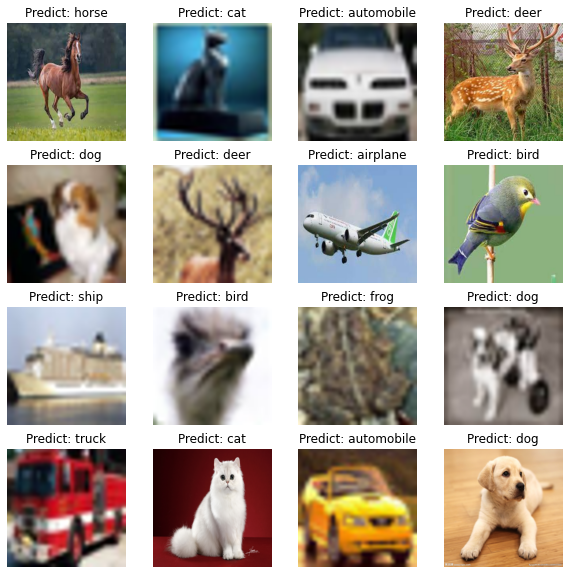

In [12]:
import os
files= os.listdir("./infer")
fig, axs = plt.subplots(4, 4,figsize=(10,10))
for index,file in enumerate(files):
    visualize_model("./infer/"+file,model,axs[index//4,index%4])
plt.show()

## **总结**

本案例使用GoogLeNet在CIFAR-10上完成了一个demo教程。首先，我们进行了数据集的加载，以及数据集的可视化分析，其次，我们按照GoogLeNet原作者提出的架构构建了网络，最后，我们在数据集上完成了GoogLeNet的训练、评估和推理。我们使用MindSpore实现了一个完整的现代卷积神经网络，包含了模型的保存和载入。

## **参考文献**

[1]. Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., ... & Rabinovich, A. (2015). Going deeper with convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1-9).\
[2]. Aston Zhang, Zachary C. Lipton, Mu Li, and Alexander J. Smola. Dive into deep learning. arXiv preprint arXiv:2106.11342, 2021.